In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import numpy as np
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
#original
TRAIN_DIR = "/gdrive/MyDrive/b_fix_dataflow/TRAIN"
TEST_DIR = "/gdrive/MyDrive/b_fix_dataflow/TEST"
LABLE_DIR = "/gdrive/MyDrive/Metadata"
CATEGORIES = ['0','1','2','3','4']
Label_Count = [0, 0, 0, 0, 0]
IMG_SIZE = 150

In [7]:
def bbox_swap(bbox1, bbox2):
    return bbox2, bbox1

def cropping(img, img_name):
    js_path = LABLE_DIR + "/" + img_name.split('.')[0] + ".json"
    js_data = json.load(open(js_path))
    bbox = np.array(js_data['annotations'][0]['bbox'],dtype=int)
    bbox = list(map(abs,bbox))
    if(bbox[1]>bbox[3]):
        bbox[1],bbox[3]=bbox_swap(bbox[1],bbox[3])
    elif(bbox[0]>bbox[2]):
        bbox[0],bbox[2]=bbox_swap(bbox[0],bbox[2]) 
    fix_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    return fix_img

def zeropadding(img):
    height, width = img.shape[0:2]
    margin = [np.abs(height - width) // 2, np.abs(height - width) // 2]
    if np.abs(height - width) % 2 != 0:
        margin[0] += 1
    if height < width:
        margin_list = [margin, [0, 0]]
    else:
        margin_list = [[0, 0], margin]
    if len(img.shape) == 3:
        margin_list.append([0,0])
    fix_img = np.pad(img, margin_list, mode='constant')
    return fix_img

# 배경 제거
def cropping_bgd(img, img_name):
    js_path = LABLE_DIR + "/" + img_name.split('.')[0] + ".json"
    js_data = json.load(open(js_path))
    bbox = np.array(js_data['annotations'][0]['bbox'],dtype=int)
    bbox = list(map(abs,bbox))
    
    rect = (bbox[0], bbox[1], bbox[2]-bbox[0], bbox[3]-bbox[1])
    mask = np.zeros(img.shape[:2], np.uint8)
    # bgdModel = np.zeros((1, 65), np.float64)
    # fgdModel = np.zeros((1, 65), np.float64)
    # cv2.grabCut(fix_img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    cv2.grabCut(img, mask, rect, None, None, 5, cv2.GC_INIT_WITH_RECT)
    mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
    fix_img = img * mask_2[:, :, np.newaxis]
    return fix_img

# # 배경 제거, json없이
# def cropping_bgd(img):
#     height, width = img.shape[0:2]
#     rect = (0, 0, width-1, height-1)
#     print(rect)
#     mask = np.zeros(img.shape[:2], np.uint8)
#     cv2.grabCut(img, mask, rect, None, None, 5, cv2.GC_INIT_WITH_RECT)
#     mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
#     fix_img = img * mask_2[:, :, np.newaxis]
#     return fix_img

1389914.3024625268


In [ ]:
#fix_2022_11_05
#이미지 배경제거


# 배경 제거, json없이
def cropping_bgd(img):
    height, width = img.shape[0:2]
    rect = (0, 0, width-1, height-1)
    print(rect)
    mask = np.zeros(img.shape[:2], np.uint8)
    cv2.grabCut(img, mask, rect, None, None, 5, cv2.GC_INIT_WITH_RECT)
    mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
    fix_img = img * mask_2[:, :, np.newaxis]
    return fix_img

testing_data = []
Label_Count = [0, 0, 0, 0, 0]

def create_data_array(arr, dir_path):
    for category in CATEGORIES:
        path = os.path.join(dir_path, category)
        class_num = CATEGORIES.index(category)
        for img_name in os.listdir(path):
            try:
                img = cv2.imread(os.path.join(path, img_name))
                img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_cropping = cropping_bgd(img_RGB)
                img_padding = zeropadding(img_cropping)
                fix_img = cv2.resize(img_padding, (IMG_SIZE, IMG_SIZE))
                arr.append([fix_img, class_num])
                Label_Count[class_num]+=1
            except Exception as e:
                pass

In [ ]:
create_data_array(testing_data,TEST_DIR)
print(len(testing_data))

NameError: ignored

In [ ]:
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    plt.imshow(testing_data[i][0])
plt.show()

In [ ]:
#normalizing, 정규화

import random

test_X = []
test_Y = []

for features, label in testing_data:
    test_X.append(features)
    test_Y.append(label)

test_X=np.array(test_X)
test_Y=np.array(test_Y)

test_X=test_X/255
test_X=np.array(test_X).reshape(-1,IMG_SIZE,IMG_SIZE,3)

print(test_X.shape)

In [ ]:
#테스트 데이터 각 단계 갯수
print(Label_Count)

In [4]:
#Model load
from keras.models import load_model
model = load_model('/gdrive/MyDrive/Model/Dataflow.h5')

In [ ]:
#Model load
from keras.models import load_model
model = load_model('/gdrive/MyDrive/Model/binary.h5')

시험 구간

In [ ]:
#confusion_matrix show
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_Y,np.argmax(predictions,axis=1)))
print(classification_report(test_Y,np.argmax(predictions,axis=1)))
confusion_mtx = confusion_matrix(test_Y,np.argmax(predictions,axis=1))

def plot_confusion_matrix(cm, CATEGORIES, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(CATEGORIES))
    plt.xticks(tick_marks, CATEGORIES, rotation=45)
    plt.yticks(tick_marks, CATEGORIES)
    plt.ylabel('True label')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment="center", color='white' if cm[i, j] > thresh else "black") 
    
    plt.tight_layout()

import itertools

plot_confusion_matrix(confusion_mtx, CATEGORIES)

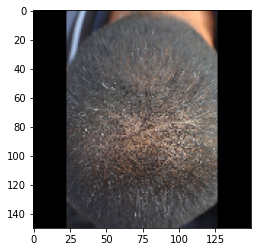

In [ ]:
plt.imshow(testing_data[54][0])
plt.show()

In [8]:
# 배경 지운 이미지 한 개
path=os.path.join(TEST_DIR,"1")
img_name="s1_432_a.png"
img = cv2.imread(os.path.join(path, img_name))
img_RGB=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_cropping = cropping_bgd(img_RGB, img_name)
img_cropping = cropping(img_RGB,img_name)
img_padding = zeropadding(img_cropping)
oneimg = cv2.resize(img_padding, (IMG_SIZE, IMG_SIZE))
#정규화
oneimg = np.array(oneimg).reshape(-1,IMG_SIZE,IMG_SIZE,3)
oneimg = oneimg/255
#plt.imshow(oneimg)
#plt.show()
# 결과
predictions_oneimg = model.predict(oneimg)
print(predictions_oneimg[0])
print(np.mean(predictions_oneimg, axis=0))
print(np.argmax(predictions_oneimg, axis=-1))

1/1 [==============================] - 7s 7s/step
[9.4401010e-08 9.3611027e-04 9.9905676e-01 7.0813494e-06 1.3321756e-09]
[9.4401010e-08 9.3611027e-04 9.9905676e-01 7.0813494e-06 1.3321756e-09]
[2]


In [ ]:
# testing_data=[]
# testing_data.append([fix_img,'1'])
# img_padding = zeropadding(img_cropping)
# fix_img = cv2.resize(img_padding, (IMG_SIZE, IMG_SIZE))

# predictions=model.predict()
# print(np.mean(predictions,axis=0))
# print(np.argmax(predictions))

(10, 150, 150, 3)


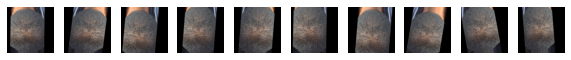

In [9]:
# 이미지 증강(size = 10)
img_generator = ImageDataGenerator(
            #rescale=1./255,
            rotation_range = 10,
            zoom_range=0.10,
            shear_range = 0.5,
            width_shift_range = 0.10,
            height_shift_range = 0.10,
            horizontal_flip = True,
            vertical_flip = False)

augment_size = 10
x_augmented=img_generator.flow(np.tile(oneimg.reshape(150*150*3),augment_size).reshape(-1,150,150,3),np.zeros(augment_size),batch_size=augment_size,shuffle=False).next()[0]
print(x_augmented.shape)

plt.figure(figsize=(10,10))
for i in range(augment_size):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    plt.imshow(x_augmented[i].reshape(IMG_SIZE,IMG_SIZE,3))
plt.show()

In [20]:
prediction = model.predict(x_augmented)
pred = np.argmax(prediction,axis=-1)
pred[4]=9
avg = np.mean(pred)

1/1 [==============================] - 0s 18ms/step


In [21]:
print(prediction)
print(pred)
print(avg)

[[2.7557664e-10 9.1199909e-05 9.9990869e-01 1.7649350e-07 4.8701116e-11]
 [3.4671518e-07 2.1498874e-02 9.7850055e-01 2.4582343e-07 4.5465406e-11]
 [1.0198559e-08 1.5547745e-04 9.9984241e-01 2.0780572e-06 2.7664340e-09]
 [1.5787311e-11 7.6011611e-06 9.9999237e-01 5.8968460e-08 1.3187570e-11]
 [9.6080740e-08 6.7966003e-03 9.9320084e-01 2.5342658e-06 4.3550549e-10]
 [3.3469902e-07 1.8485732e-02 9.8151243e-01 1.5713237e-06 5.7098615e-10]
 [1.4182917e-09 4.5415432e-05 9.9994755e-01 7.0725182e-06 2.2227482e-09]
 [1.3997619e-06 8.4911242e-02 9.1508710e-01 2.4552449e-07 3.5326456e-10]
 [1.8244406e-10 4.6365716e-05 9.9995255e-01 1.0450867e-06 2.5713908e-11]
 [3.1887267e-11 8.2333936e-06 9.9998987e-01 1.8711884e-06 4.1308186e-11]]
[2 2 2 2 9 2 2 2 2 2]
2.7


In [ ]:
# plt.imshow(x_augmented[0].reshape(IMG_SIZE,IMG_SIZE,3))
# plt.colorbar()
# plt.show()

In [ ]:
# temp = x_augmented[0].reshape(-1,IMG_SIZE,IMG_SIZE,3)
# predictions_temp = model.predict(temp)
# print(np.mean(predictions_temp, axis=0))
# print(np.argmax(predictions_temp))

1/1 [==============================] - 0s 16ms/step
[4.0649371e-07 1.9816121e-01 8.0183840e-01 4.3898851e-08 1.5724200e-11]
2


In [ ]:
def get_result(augment):
  result = 0
  augment_size = len(augment)
  
  for i in range(augment_size):
    temp = augment[i].reshape(IMG_SIZE, IMG_SIZE, 3)
    temp = temp.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    pred = model.predict(temp, verbose=0)
    result += np.argmax(pred)

  result = float(result / augment_size)
  return result

In [ ]:
result = get_result(x_augmented)
print(result)

1.55
